# Optimización de Hiperparámetros

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neural_network
import sklearn.ensemble
import matplotlib.pyplot as plt

## Preprocesamiento

In [2]:
np.random.seed(11)

In [3]:
gender = pd.read_csv("data/gender.csv")

In [4]:
features = gender.iloc[:,:-1] # Seleccionamos sólo las características del conjunto de datos
label = gender["Gender"] # Seleccionamos la etiqueta del conjunto de datos

In [5]:
enc = sklearn.preprocessing.OneHotEncoder() # Instanciamos nuestro One-Hot Encoder
features_transformed = pd.DataFrame(
    enc.fit_transform(features).todense(), # Entrenamos nuestro transformador y transformamos las características
    columns = enc.get_feature_names()
)

## Modelamiento

Vamos a seleccionar la combinación de hiperparámetros que nos ofrezca la mejor métrica de rendimiento. Primero se establece una matriz de hiperparámetros y se generan todas las combinaciones de hiperparámetros. Con cada una de las combinaciones se realiza el entrenamiento de modelos utilizando la técnica de validación cruzada. Se establecerá la mejor combinación de hiperparámetros según el promedio de resultados sonbre el conjunto de prueba.

In [6]:
def grid_search(estimator,param_grid,features,label):
    """
    Recibe un estimador, una matriz de hiperparámetros, una matriz de características y un arreglo de etiquetas.
    Retorna un objeto del tipo GridSearchCV
    """
    gs = sklearn.model_selection.GridSearchCV( # Instanciamos un objeto de grid search
        estimator, # Este es el estimador al cual le buscaremos los mejores hiperparámetros.
        scoring = 'roc_auc', # Esta es la métrica de rendimiento que utilizaremos.
        param_grid = param_grid, # Acá pasamos el espacio de hiperparámetros a probar
        cv = sklearn.model_selection.StratifiedKFold( # Utilizamos una validación cruzada estratificada
                n_splits = 3, # El conjunto de datos se divide en 3
                shuffle = True # Desordenamos el conjunto de datos antes de dividirlo
            )
    )
    gs.fit(features,label) # Entrenamos el grid search
    return gs

Establecemos nuestro espacio de hiperparámetros según el algoritmo a utilizar.

In [7]:
rf_grid = {
    'n_estimators': [50, 100, 200, 500],
    'min_samples_split': range(2,5)
}

Ajustamos un grid search para random forest.

In [8]:
rf_gs = grid_search(
    estimator = sklearn.ensemble.RandomForestClassifier(),
    param_grid = rf_grid,
    features = features_transformed,
    label = label
)

Este es el resumen de los resultados del grid search.

In [9]:
rf_gs_results = pd.DataFrame(rf_gs.cv_results_).sort_values("rank_test_score")
rf_gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.049786,0.001373,0.005520,9.276541e-04,2,50,"{'min_samples_split': 2, 'n_estimators': 50}",0.719008,0.599174,0.595041,0.637741,0.057489,1
3,0.483781,0.026978,0.033036,8.184479e-04,2,500,"{'min_samples_split': 2, 'n_estimators': 500}",0.727273,0.590909,0.512397,0.610193,0.088776,2
8,0.047835,0.002752,0.004869,1.562364e-05,4,50,"{'min_samples_split': 4, 'n_estimators': 50}",0.677686,0.561983,0.570248,0.603306,0.052703,3
4,0.052695,0.002885,0.004880,1.946680e-07,3,50,"{'min_samples_split': 3, 'n_estimators': 50}",0.743802,0.603306,0.458678,0.601928,0.116405,4
1,0.098577,0.006204,0.008142,4.534111e-04,2,100,"{'min_samples_split': 2, 'n_estimators': 100}",0.714876,0.537190,0.537190,0.596419,0.083762,5


Esta es la mejor combinación de hiperparámetros.

In [10]:
rf_gs.best_params_

{'min_samples_split': 2, 'n_estimators': 50}

Realizamos el mismo procedimiento para el perceptrón multicapa.

In [11]:
mlp_grid = {
    'hidden_layer_sizes': [(50), (50,50), (100), (100,100)],
    'max_iter': [5000],
    'activation': ['identity', 'logistic', 'tanh', 'relu']
}

In [12]:
mlp_gs = grid_search(
    estimator = sklearn.neural_network.MLPClassifier(),
    param_grid = mlp_grid,
    features = features_transformed,
    label = label
)

In [13]:
mlp_gs_results = pd.DataFrame(mlp_gs.cv_results_).sort_values("rank_test_score")
mlp_gs_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,0.114192,0.144911,0.002278,0.000459,logistic,"(50, 50)",5000,"{'activation': 'logistic', 'hidden_layer_sizes...",0.570248,0.690083,0.698347,0.652893,0.058536,1
13,0.138267,0.003197,0.003253,0.000919,relu,"(50, 50)",5000,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.586777,0.685950,0.673554,0.648760,0.044120,2
15,0.218959,0.009560,0.002285,0.000455,relu,"(100, 100)",5000,"{'activation': 'relu', 'hidden_layer_sizes': (...",0.611570,0.648760,0.615702,0.625344,0.016643,3
10,0.203008,0.003984,0.002278,0.000460,tanh,100,5000,"{'activation': 'tanh', 'hidden_layer_sizes': 1...",0.619835,0.615702,0.590909,0.608815,0.012774,4
12,0.218292,0.015039,0.002288,0.000452,relu,50,5000,"{'activation': 'relu', 'hidden_layer_sizes': 5...",0.603306,0.615702,0.599174,0.606061,0.007023,5


In [14]:
mlp_gs.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (50, 50), 'max_iter': 5000}

## Conclusión

Exploremos cómo se distribuye el rendimiento de nuestros modelos a lo largo de la búsqueda de hiperparámetros.

In [15]:
def plot_grid_search(results,title):
    """
    Recibe un DataFrame de resultados de un grid search y un título.
    Devuelve una visualización con boxplot de los resultados de la grid search
    """
    scores = results.filter(regex=r"split\d_test_score")
    params = results.params
    plt.boxplot(scores.values.transpose(),showmeans=True)
    plt.title(title)
    plt.show()

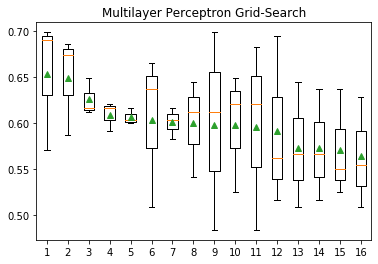

In [16]:
plot_grid_search(mlp_gs_results,title="Multilayer Perceptron Grid-Search")

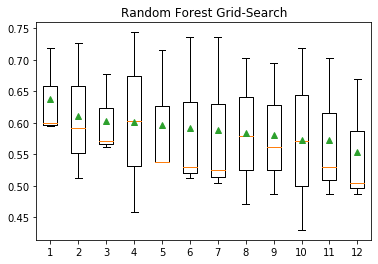

In [17]:
plot_grid_search(rf_gs_results,title="Random Forest Grid-Search")